In [1]:
import os
from os import listdir
os.environ['JAX_PLATFORMS'] = ''
os.environ["KERAS_BACKEND"] = "jax"

import numpy as np
import pandas as pd
from glob import glob
import cv2
from cv2 import imread, imshow, resize
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter, ImageEnhance

import tensorflow as tf
import keras
from keras import ops
from keras import layers
from keras.layers import Dense, Dropout
from keras.layers import *
from keras.models import *
from keras.utils import *
from keras.preprocessing import image_dataset_from_directory

from sklearn.metrics import confusion_matrix
import seaborn as sns
import shutil

# 1. Load and preprocessing data

In [2]:
base_path = "E:/UDA_LEARNING/UDA_DO AN TRI TUE NHAN TAO & UNG DUNG/BREAST CANCER/data/IDC_regular_ps50_idx5"
folder = listdir(base_path)
len(folder)
print(folder[:5])

['10253', '10254', '10255', '10256', '10257']


In [3]:
# how many image input?
total_images = 0
for n in range(len(folder)):
    patient_id = folder[n]
    for c in [0, 1]:
        patient_path = base_path + "/" + patient_id
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        total_images += len(subfiles)

print(total_images)

277524


In [4]:
# split patient into frame: patient_id, path, target (id patient, path/to/patient and label)
data = pd.DataFrame(index=np.arange(0, total_images), columns=["patient_id", "path", "target"])

k = 0
for n in range(len(folder)):
    patient_id = folder[n]
    patient_path = base_path + "/" + patient_id 
    for c in [0,1]:
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        for m in range(len(subfiles)):
            image_path = subfiles[m]
            data.loc[k, "path"] = class_path + image_path
            data.loc[k, "target"] = c
            data.loc[k, "patient_id"] = patient_id
            k += 1  

data.head()

,patient_id,path,target
0,10253,E:/UDA_LEARNING/UDA_DO AN TRI TUE NHAN TAO & U...,0
1,10253,E:/UDA_LEARNING/UDA_DO AN TRI TUE NHAN TAO & U...,0
2,10253,E:/UDA_LEARNING/UDA_DO AN TRI TUE NHAN TAO & U...,0
3,10253,E:/UDA_LEARNING/UDA_DO AN TRI TUE NHAN TAO & U...,0
4,10253,E:/UDA_LEARNING/UDA_DO AN TRI TUE NHAN TAO & U...,0


In [5]:
Pos_path = data.groupby("target").get_group(0)
Neg_path = data.groupby('target').get_group(1)

In [6]:
print(Pos_path[:5])
print(len(Pos_path))

  patient_id                                               path target
0      10253  E:/UDA_LEARNING/UDA_DO AN TRI TUE NHAN TAO & U...      0
1      10253  E:/UDA_LEARNING/UDA_DO AN TRI TUE NHAN TAO & U...      0
2      10253  E:/UDA_LEARNING/UDA_DO AN TRI TUE NHAN TAO & U...      0
3      10253  E:/UDA_LEARNING/UDA_DO AN TRI TUE NHAN TAO & U...      0
4      10253  E:/UDA_LEARNING/UDA_DO AN TRI TUE NHAN TAO & U...      0
198738


In [7]:
print(Neg_path[0:5])
print(len(Neg_path))

    patient_id                                               path target
479      10253  E:/UDA_LEARNING/UDA_DO AN TRI TUE NHAN TAO & U...      1
480      10253  E:/UDA_LEARNING/UDA_DO AN TRI TUE NHAN TAO & U...      1
481      10253  E:/UDA_LEARNING/UDA_DO AN TRI TUE NHAN TAO & U...      1
482      10253  E:/UDA_LEARNING/UDA_DO AN TRI TUE NHAN TAO & U...      1
483      10253  E:/UDA_LEARNING/UDA_DO AN TRI TUE NHAN TAO & U...      1
78786


In [8]:
Pos_path.columns

Index(['patient_id', 'path', 'target'], dtype='object')

In [9]:
lowerIndex = 0
upperIndex = 50000

Pos_train_path = list(Pos_path[lowerIndex: upperIndex]['path'])
Pos_train_target = list(Pos_path[lowerIndex: upperIndex]['target'])

print(len(Pos_train_path))
print(len(Pos_train_target))

50000
50000


In [10]:
Neg_train_path = list(Neg_path[lowerIndex: upperIndex]['path'])
Neg_train_target = list(Neg_path[lowerIndex: upperIndex]['target'])

print(len(Pos_train_path))
print(len(Neg_train_target))

50000
50000


In [11]:
x_train = []
y_train = []
x_test = []
y_test = []

WIDTH = 50
HEIGHT = 50

for path in Pos_train_path:
    origImageSize = imread(path)
    resizedImage = resize(origImageSize, (WIDTH, HEIGHT), interpolation=cv2.INTER_CUBIC)
    x_train.append(resizedImage)

for path in Neg_train_path:
    origImageSize = imread(path)
    resizedImage = resize(origImageSize, (WIDTH, HEIGHT), interpolation=cv2.INTER_CUBIC)
    x_train.append(resizedImage)

In [12]:
print(len(x_train))
y_train = Pos_train_target + Neg_train_target
print(len(y_train))

100000
100000


In [13]:
combined = list(zip(x_train, y_train))
np.random.shuffle(combined)
x_train, y_train = zip(*combined)

In [14]:
x_train = np.array(x_train)
# x_train = np.array(x_train)/255.0
y_train = np.array(y_train)

# 2. Build Transformer model

In [15]:
num_classes = 2
input_shape = (50, 50, 3)

# (x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
# print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (100000, 50, 50, 3) - y_train shape: (100000,)


In [16]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 50  # For real training, use num_epochs=100. 10 is a test value
image_size = 50  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [
    2048,
    1024,
]  # Size of the dense layers of the final clas

In [17]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
# data_augmentation.layers[0].adapt(x_train)

In [18]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

### Implement patch creation as a layer

In [19]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = keras.ops.image.extract_patches(images, size=self.patch_size)
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config

Image size: 50 X 50
Patch size: 6 X 6
Patches per image: 64
Elements per patch: 108


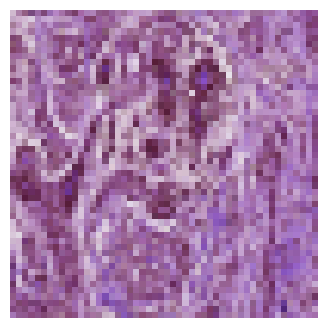

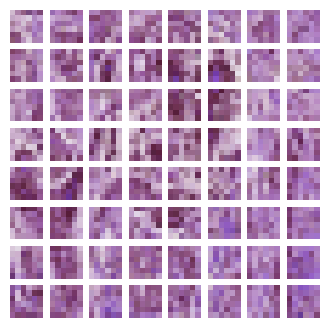

In [20]:
plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = ops.image.resize(
    ops.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = ops.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(ops.convert_to_numpy(patch_img).astype("uint8"))
    plt.axis("off")

### Implement the patch encoding layer

In [21]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config

In [22]:
def create_vit_classifier():
    inputs = keras.Input(shape=input_shape)
    # Augment data.
    # augmented = data_augmentation(inputs)
    augmented = inputs
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1101s 3s/step - accuracy: 0.5454 - loss: 1.4118 - val_accuracy: 0.7831 - val_loss: 0.4888
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1017s 3s/step - accuracy: 0.7862 - loss: 0.4684 - val_accuracy: 0.8409 - val_loss: 0.3879
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 927s 3s/step - accuracy: 0.8360 - loss: 0.3815 - val_accuracy: 0.8536 - val_loss: 0.3361
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 940s 3s/step - accuracy: 0.8548 - loss: 0.3399 - val_accuracy: 0.8709 - val_loss: 0.3021
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 844s 3s/step - accuracy: 0.8628 - loss: 0.3211 - val_accuracy: 0.8681 - val_loss: 0.3367
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 886s 3s/step - accuracy: 0.8661 - loss: 0.3168 - val_accuracy: 0.8608 - val_loss: 0.3247
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 811s 3s/step - accuracy: 0.8724 - loss: 0.3032 - val_accuracy: 0.8772 - val_loss: 0.3112
Epoch 8/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 818s 3s/step - accuracy: 0.8677 - loss: 0.3083 - val_ac

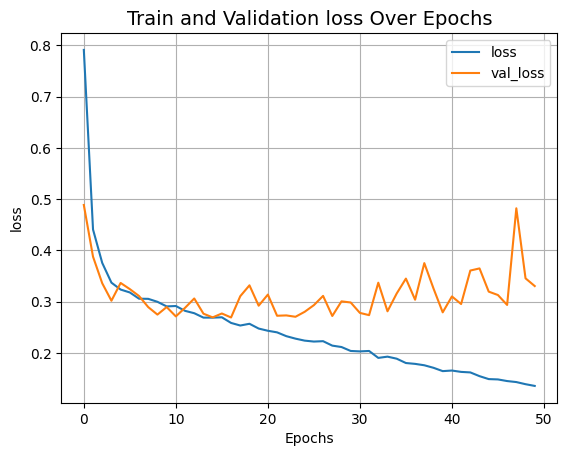

In [23]:
def run_experiment(model):
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            # keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "BreastCancerModel_Transformer_checkpoint.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.2,
        callbacks=[checkpoint_callback],
    )

    # model.load_weights(checkpoint_filepath)
    # _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    # print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    # print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)


def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("loss")
# plot_history("top-5-accuracy")    

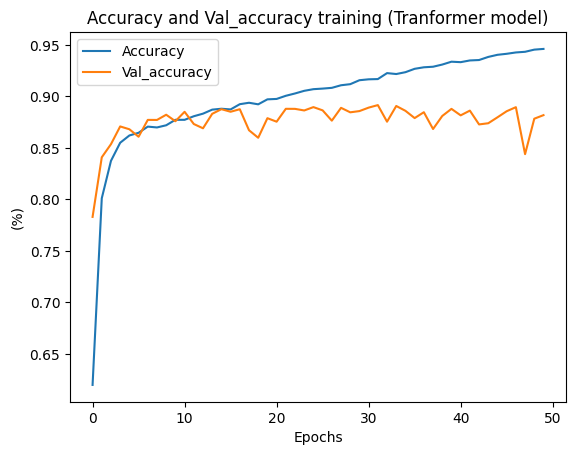

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('(%)')
plt.title('Accuracy and Val_accuracy training (Tranformer model)')
plt.legend(['Accuracy', 'Val_accuracy'])
plt.show()

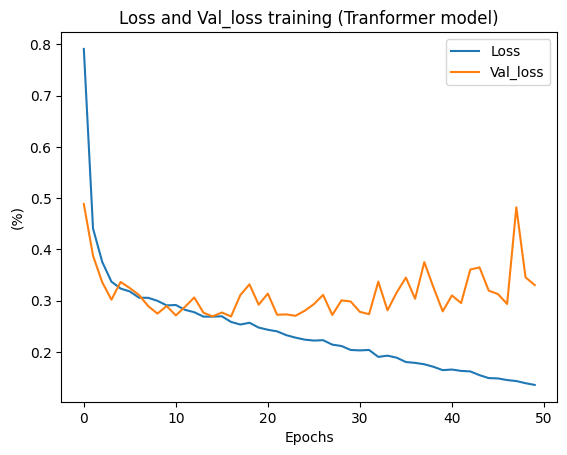

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('(%)')
plt.title('Loss and Val_loss training (Tranformer model)')
plt.legend(['Loss', 'Val_loss'])
plt.show()